In [1]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torchinfo import summary
import sys

# データセット

In [2]:
timeline = np.arange(10000)
epochs = 100

def sinnp(n, line):
    return np.sin(line * n / 100)

def cosnp(n, line):
    return np.cos(line * n / 1000)

raw_data = (sinnp(1, timeline) + sinnp(3, timeline) + sinnp(10, timeline) + cosnp(5, timeline) + cosnp(7, timeline)) / 5
raw_data = raw_data + (np.random.rand(len(timeline)) * 0.5)# ノイズ項

/home/work/.cache/pypoetry/virtualenvs/godaddy-3UyvmeC2-py3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/work/.cache/pypoetry/virtualenvs/godaddy-3UyvmeC2-py3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/work/.cache/pypoetry/virtualenvs/godaddy-3UyvmeC2-py3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/work/.cache/pypoetry/virtualenvs/godaddy-3UyvmeC2-py3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/hom

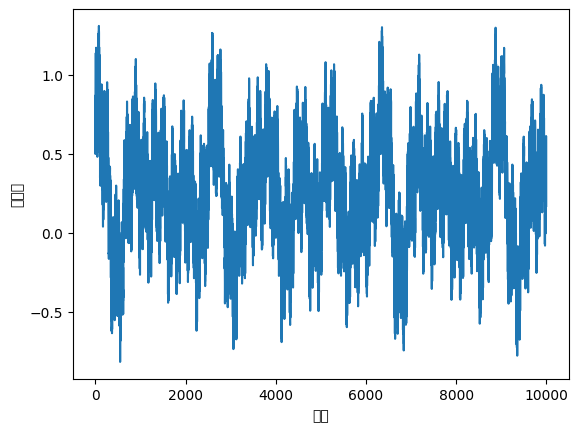

In [3]:
plt.plot(timeline, raw_data)
plt.xlabel("時間")
plt.ylabel("測定値")
plt.show()

In [4]:
df = pl.DataFrame({"raw_data": raw_data})

In [5]:
input_features = 8
output_dim = 1

In [6]:
for s in range(output_dim):
    i = s + 0     
    if f"y{s+1}" not in df:
        df = df.with_columns(pl.col("raw_data").shift(i).alias(f"y{s+1}"))

In [7]:
for s in range(input_features):
    i = s + output_dim
    if f"x{s+1}" not in df:
        df = df.with_columns(pl.col("raw_data").shift(i).alias(f"x{s+1}"))        

In [8]:
df = df.drop_nulls()
df = df.with_columns(pl.Series([x + 1 for x in range(df.shape[0])]).alias("id"))

In [9]:
train_df = df.filter(pl.col("id") < 4000)
test_df = df.filter(pl.col("id") >= 4000)

input_dim = 8
train_x = torch.tensor(train_df.select([pl.col(f"x{i+1}") for i in range(input_dim)]).to_numpy()).cuda()
train_y = torch.tensor(train_df.select([pl.col("y1")]).to_numpy()).cuda()
test_x = torch.tensor(test_df.select([pl.col(f"x{i+1}") for i in range(input_dim)]).to_numpy()).cuda()
test_y = torch.tensor(test_df.select([pl.col("y1")]).to_numpy()).cuda()

train_x = train_x.reshape(train_df.shape[0],1,input_dim).float()
train_y = train_y.reshape(train_df.shape[0],1,1).float()
test_x = test_x.reshape(test_df.shape[0],1,input_dim).float()
test_y = test_y.reshape(test_df.shape[0],1,1).float()

# Modeling

## learning

In [10]:
def fit(model, train_x, train_y, test_x, test_y):
    
    epoch = 2000
    model = model.cuda()
    
    criterion = nn.MSELoss().double().cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
    
    test_losslist = []
    train_losslist = []
    for e in tqdm(range(epoch)):
        optimizer.zero_grad()
        output = model(train_x)
        loss = criterion(output.reshape(-1), train_y.reshape(-1))    
        loss.backward()
        optimizer.step()  
        
        test_loss = calc_score(model, test_x, test_y)
        
        train_losslist.append(loss.cpu().detach().numpy().tolist())
        test_losslist.append(test_loss)
    return train_losslist, test_losslist, model

def calc_score(model, test_x, test_y):
    
    with torch.no_grad():
        output = model(test_x)
        d = output.cpu().reshape(-1)
        ans = test_y.reshape(-1).cpu()
        
        return ((d-ans)@(d-ans)).numpy().tolist()

## model

### CONV1 + Linear

In [11]:
class conv1d_linear(nn.Module):
        
    def __init__(self):
        super(conv1d_linear, self).__init__()
        
        self.conv1d = nn.Conv1d(1, 8,  kernel_size = 2, stride = 1)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(56, 1)
        
        
    def forward(self,x):
        x = self.conv1d(x)
        x = x.view(x.size()[0],-1)                
        x = self.linear(x)

        return x



### MLP

In [12]:
class MLP(nn.Module):
        
    def __init__(self):
        super(MLP, self).__init__()
        
        self.linear1 = nn.Linear(8, 20)
        self.linear2 = nn.Linear(20, 10)
        self.linear3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()        
                
        
    def forward(self,x):
        x = self.linear1(x)
        self.relu(x)
        x = self.linear2(x)
        self.relu(x)
        x = self.linear3(x)        

        return x

### LSTM + linear

In [13]:
class customLSTM(nn.Module):
    
    def __init__(self):
        super(customLSTM, self).__init__()
        
        self.LSTM = nn.LSTM(8, 10)
        self.linear = nn.Linear(10, 1)
        
    def forward(self, x):
        x, hidden = self.LSTM(x)
        x = self.linear(x.view(len(x), -1))        
        
        return x

### conv1cnn + LSTM  + linear

In [14]:
class conv1d_LSTM(nn.Module):
    
    def __init__(self):
        super(conv1d_LSTM, self).__init__()
        
        self.conv1d = nn.Conv1d(1, 8,  kernel_size = 2, stride = 1)
        self.relu = nn.ReLU()
        
        self.LSTM = nn.LSTM(56, 30)
        self.linear = nn.Linear(30, 1)
        
    def forward(self, x):
        x = self.conv1d(x)
        x = x.view(x.size()[0],-1)                
        x, hidden = self.LSTM(x)
        x = self.linear(x.view(len(x), -1))        
        
        return x

In [15]:
trainloss1, testloss1, mode1 = fit(MLP().cuda(), train_x, train_y, test_x, test_y)        
print(testloss1[-1])

trainloss2, testloss2, mode2 = fit(conv1d_linear().cuda(), train_x, train_y, test_x, test_y)        
print(testloss2[-1])

trainloss3, testloss3, mode3 = fit(customLSTM().cuda(), train_x, train_y, test_x, test_y)        
print(testloss3[-1])

trainloss4, testloss4, mode4 = fit(conv1d_LSTM().cuda(), train_x, train_y, test_x, test_y)        
print(testloss4[-1])

  0%|          | 0/2000 [00:00<?, ?it/s]

166.23800659179688


  0%|          | 0/2000 [00:00<?, ?it/s]

164.31260681152344


  0%|          | 0/2000 [00:00<?, ?it/s]

188.25802612304688


  0%|          | 0/2000 [00:00<?, ?it/s]

171.68272399902344


<Axes: >

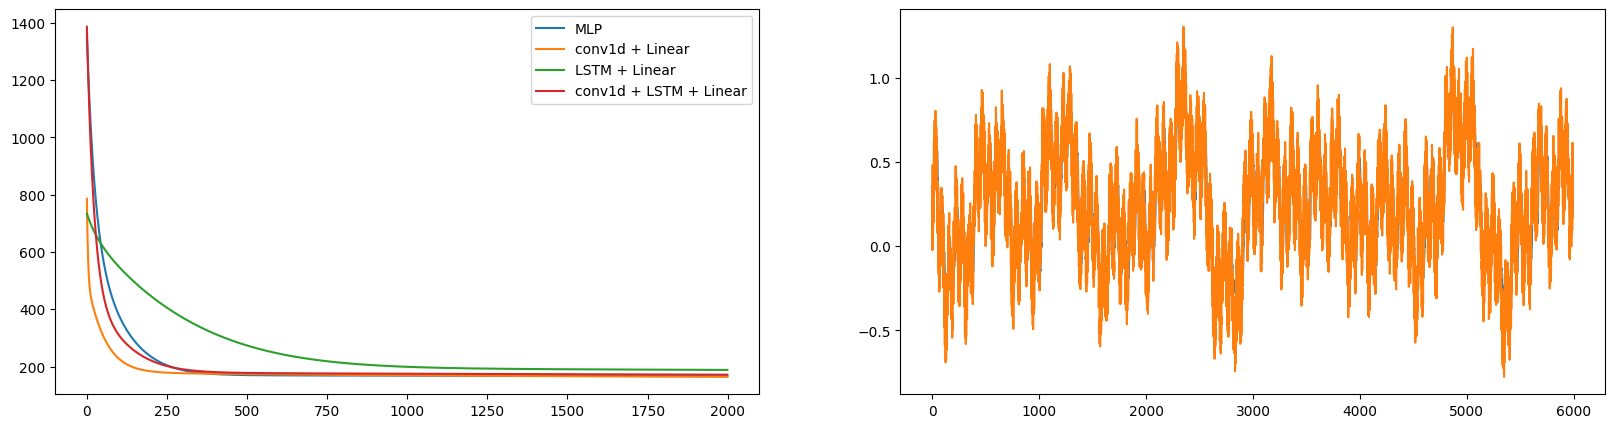

In [16]:
fig,axes = plt.subplots(1, 2, figsize = (20, 5))
sns.lineplot(testloss1, ax=axes[0], label = "MLP")
sns.lineplot(testloss2, ax=axes[0], label = "conv1d + Linear")
sns.lineplot(testloss3, ax=axes[0], label = "LSTM + Linear")
sns.lineplot(testloss4, ax=axes[0], label = "conv1d + LSTM + Linear")

with torch.no_grad():
    output = mode3(test_x)
    d = output.cpu().reshape(-1)    

sns.lineplot(d, ax = axes[1])
sns.lineplot(test_y.cpu().reshape(-1), ax = axes[1])